In [107]:
import time, json, glob, os

import pandas as pd
import numpy as np

from py2neo import Graph, Node, Relationship
from tqdm import tqdm
from __future__ import print_function

from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import matplotlib as mpl
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
mpl.style.use('seaborn-muted')
sns.set(style='whitegrid')

In [43]:
graph = Graph("bolt://neo4j-magone:7687", auth=('neo4j','myneo'))

n_nodes = len(graph.nodes)
n_edges = len(graph.relationships)
print("Connected to graph with {:,} nodes and {:,} edges!".format(n_nodes, n_edges))

Connected to graph with 278,076,495 nodes and 1,842,505,331 edges!


In [44]:
def run_query(query, graph, print_query=False, run_query=True, 
              print_only=False, to_df=False):
    df = 1
    if print_only: 
        print_query = True
        run_query = False
    start_time = time.time()
    if print_query:
        print(query)
    if run_query:
        if to_df:
            df = graph.run(query).to_data_frame()
        else:
            graph.run(query)
    end_time = time.time()
    minutes_elapsed = (end_time-start_time)/60
    print("Query completed in {:.2f} minutes.".format(minutes_elapsed))
    return df

In [153]:
n_years_to_track = 15
min_year = 1950
citation_fun = lambda x: 'size((:Quanta {{year:q.year+{}}})-[:CITES]->(q)) as c{}'.format(x,x)
citation_string = '\n'+',\n'.join([citation_fun(i) for i in range(n_years_to_track)])

# query = """
# MATCH (q:Quanta) 
# WHERE q.year<=2018-{} AND q.year>{} AND size((:Quanta)-[:CITES]->(q))>1000
# WITH q, size((:Quanta)-[:CITES]->(q)) as numCitations
# ORDER BY numCitations DESC
# LIMIT 1000
# RETURN q.title as title, q.id as id, {}""".format(n_years_to_track, min_year, citation_string)

query = """
MATCH (q:Quanta) 
WHERE q.year<=2018-{} AND q.year>{} AND size((:Quanta)-[:CITES]->(q))>100
RETURN q.title as title, q.id as id, {}
LIMIT 5000""".format(n_years_to_track, min_year, citation_string)

df = run_query(query, graph, to_df=True, print_only=False)

Query completed in 13.24 minutes.


In [154]:
citation_columns = ['c{}'.format(i) for i in range(n_years_to_track)]
name_columns = ['title', 'id'] 

df = df[citation_columns + name_columns]
X = df[citation_columns].values

df.head()

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,title,id
0,0,0,0,1,2,1,6,0,2,3,3,3,3,6,9,The Determination of Pore Volume and Area Dist...,002debac-979a-4f09-b430-0ff15b825eb6
1,0,0,0,2,0,0,5,2,1,1,1,2,4,3,3,Effect of alkali on diphosphopyridine nucleotide.,006983b8-99a4-4bbf-826d-ef018cf623ae
2,1,5,1,5,7,7,8,5,3,4,6,4,1,3,1,The Kidney ; medical and surgical diseases,013395ae-7a69-4f35-94ba-5baf98674fa2
3,0,6,14,9,9,3,12,7,6,2,7,5,4,7,1,Blood Lipids and Human Atherosclerosis II. The...,01465e39-b673-44cb-9a1b-7bbbebbec0a5
4,2,2,0,4,3,3,0,1,0,0,4,2,1,1,3,Studies on the origin of cultivated plants.,01680339-a601-49a6-9ac3-646e42f29c6a


<Figure size 1152x720 with 0 Axes>

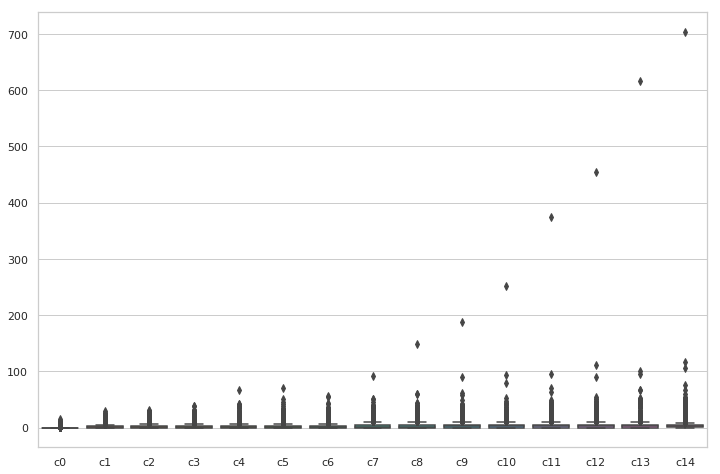

<Figure size 1152x720 with 0 Axes>

In [155]:
sns.boxplot(data=df[citation_columns])
plt.figure(figsize=(16,10))

### PCA Analysis

In [156]:
# PCA Analysis of Citation Patterns 
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
for i in range(3):
    print('Explained variance of principal component {}: {:.2%}'.format(
        i+1, pca.explained_variance_ratio_[i]))

Explained variance of principal component 1: 81.62%
Explained variance of principal component 2: 10.14%
Explained variance of principal component 3: 1.45%


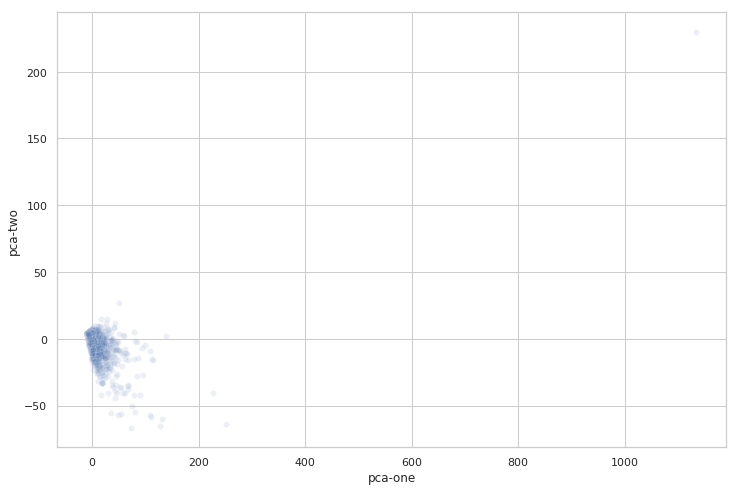

In [159]:
# Plot two components
sns.scatterplot(
    x="pca-one", y="pca-two",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.1
)

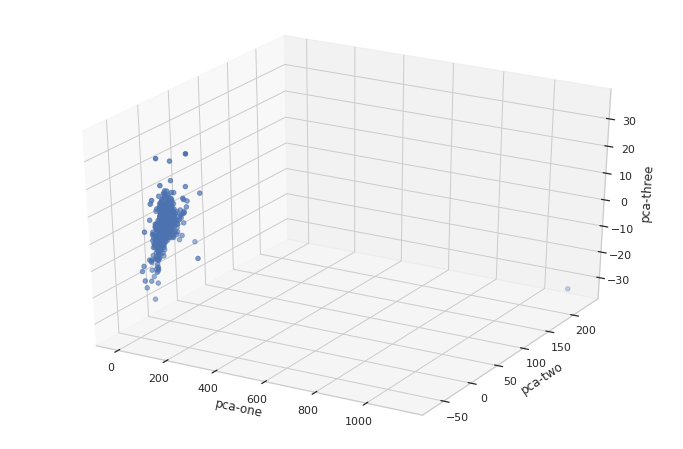

In [158]:
# Plot three components
ax = plt.gca(projection='3d')
ax.scatter(
    xs=df["pca-one"], 
    ys=df["pca-two"], 
    zs=df["pca-three"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

### T-SNE

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=1000)
tsne_results = tsne.fit_transform(X)

df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.010s...
[t-SNE] Computed neighbors for 5000 samples in 0.684s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000000


In [ ]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)